### Chuẩn bị dữ liệu

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Load data
data = pd.read_csv("AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data = data['Passengers']

### Trực quan hóa dữ liệu

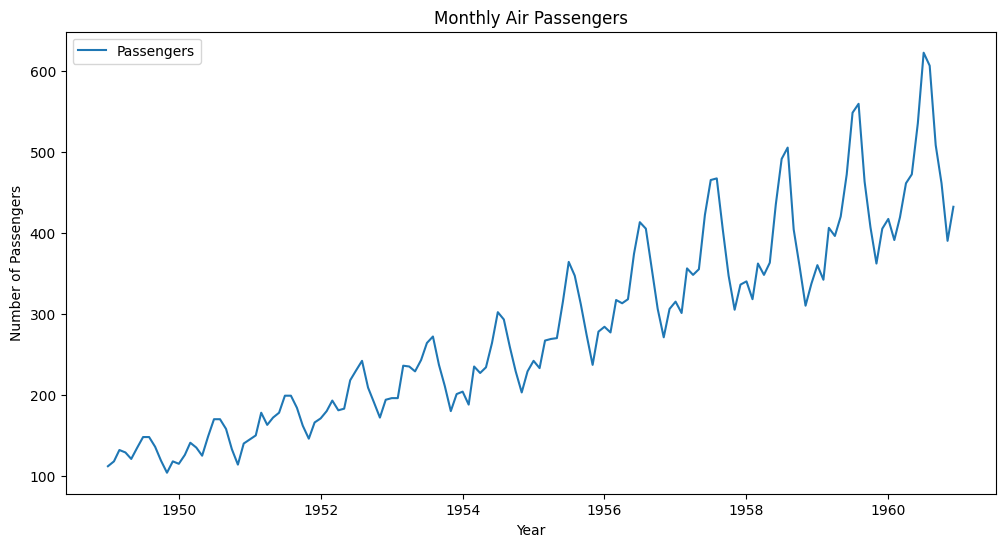

In [16]:
# 2. Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data, label='Passengers')
plt.title('Monthly Air Passengers')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

### Kiểm tra tính dừng

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
Data is not stationary. Differencing is required.


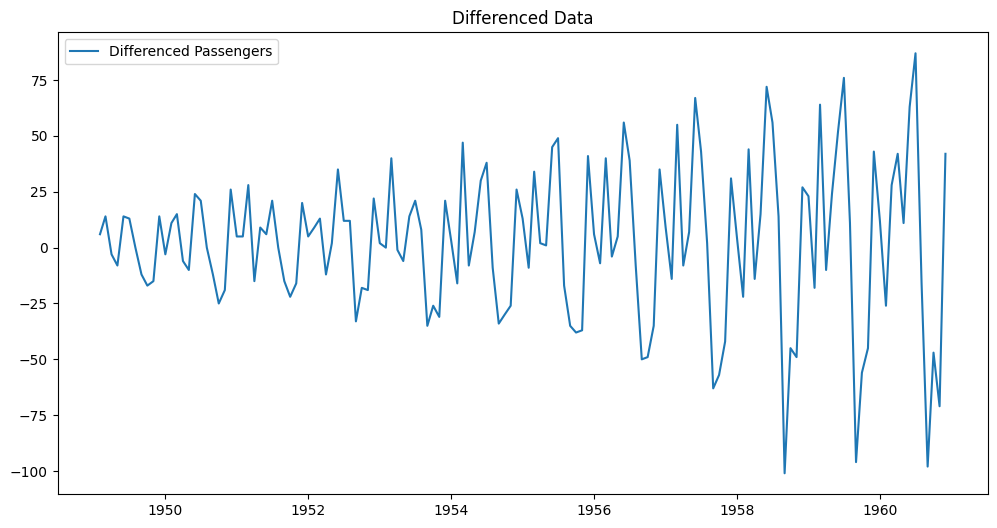

ADF Statistic after differencing: -2.8292668241699994
p-value after differencing: 0.0542132902838255


In [17]:
result = adfuller(data)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Data is not stationary. Differencing is required.")
    data_diff = data.diff().dropna()
    
    # Plot differenced data
    plt.figure(figsize=(12, 6))
    plt.plot(data_diff, label='Differenced Passengers')
    plt.title('Differenced Data')
    plt.legend()
    plt.show()
    
    # Re-check stationarity
    result_diff = adfuller(data_diff)
    print("ADF Statistic after differencing:", result_diff[0])
    print("p-value after differencing:", result_diff[1])

### Sai phân lần 2

In [18]:
data_diff2 = data_diff.diff().dropna()
result_diff2 = adfuller(data_diff2)
print("ADF Statistic after second differencing:", result_diff2[0])
print("p-value after second differencing:", result_diff2[1])

ADF Statistic after second differencing: -16.384231542468505
p-value after second differencing: 2.7328918500142407e-29


### Áp dụng ACF và PACF để dự đoán thủ công p và q

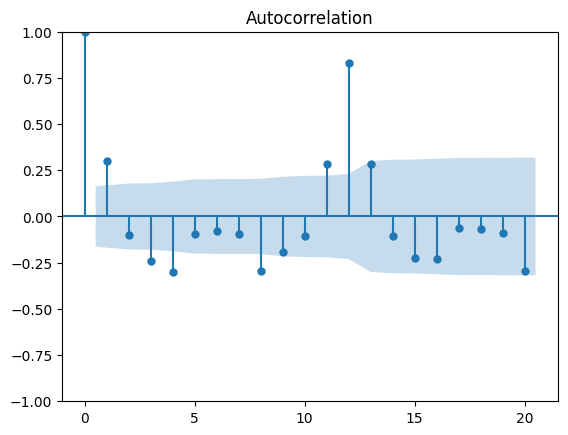

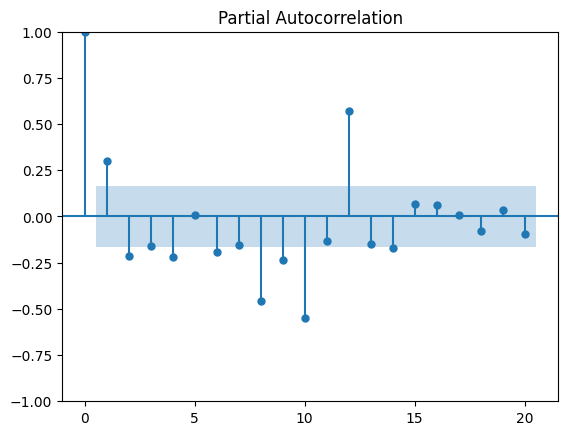

In [9]:
# 4. Plot ACF and PACF
plot_acf(data_diff, lags=20)
plt.show()

plot_pacf(data_diff, lags=20)
plt.show()

### Huấn luyện model ARIMA với tham số khởi tạo

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Mean Absolute Error (MAE): 115.32253364519693
Mean Squared Error (MSE): 16799.24925141921
Root Mean Squared Error (RMSE): 129.61191786027706


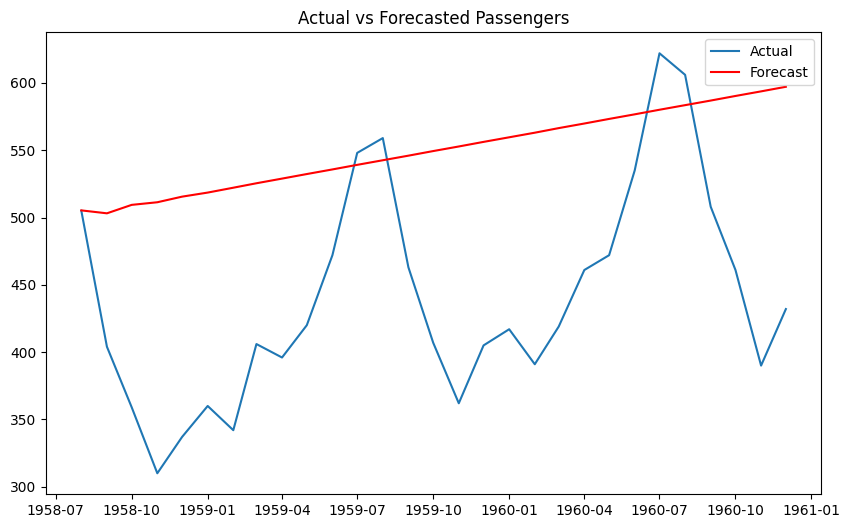

In [21]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Chia dữ liệu thành train và test (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Huấn luyện mô hình ARIMA với tham số (1, 2, 2)
model = ARIMA(train, order=(1, 2, 2))
model_fit = model.fit()

# Dự báo trên tập test
forecast = model_fit.forecast(steps=len(test))

# Tính MAE, MSE và RMSE giữa giá trị dự báo và giá trị thực tế
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

# In kết quả
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Vẽ đồ thị so sánh giá trị thực tế và giá trị dự báo
plt.figure(figsize=(10, 6))
plt.plot(test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Actual vs Forecasted Passengers')
plt.legend()
plt.show()


### Áp dụng GridSearch để tìm tham số phù hợp cho SARIMAX

In [22]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import pickle

# Đọc dữ liệu
data = pd.read_csv("AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data = data['Passengers']

# Hàm đánh giá mô hình SARIMA (chỉ sử dụng RMSE)
def evaluate_sarima_model(data, order, seasonal_order):
    try:
        train_size = int(len(data) * 0.8)
        train, test = data[:train_size], data[train_size:]
        
        model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        predictions = model_fit.forecast(steps=len(test))
        
        rmse = np.sqrt(mean_squared_error(test, predictions))  # RMSE
        
        return rmse
    except Exception as e:
        print(f"Error: {e}")
        return float('inf')

# Dải tham số cho ARIMA
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)

# Dải tham số cho phần mùa vụ
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m_values = [12]

# Tìm kiếm tổ hợp tốt nhất dựa trên RMSE
best_rmse = float('inf')
best_order = None
best_seasonal_order = None

warnings.filterwarnings("ignore")  # Tắt cảnh báo

# Lặp qua tất cả các tổ hợp của các tham số
for order in product(p_values, d_values, q_values):
    for seasonal_order in product(P_values, D_values, Q_values, m_values):
        rmse = evaluate_sarima_model(data, order, seasonal_order)
        
        # Cập nhật kết quả tốt nhất dựa trên RMSE
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
            best_seasonal_order = seasonal_order

# In kết quả
print(f"Best ARIMA order (based on RMSE): {best_order} with seasonal order: {best_seasonal_order} and RMSE: {best_rmse}")

# Huấn luyện lại mô hình với tham số tốt nhất (theo RMSE)
model_sarima_best = SARIMAX(data, order=best_order, seasonal_order=best_seasonal_order)
model_fit_sarima_best = model_sarima_best.fit()
print(model_fit_sarima_best.summary())

# Lưu mô hình tốt nhất
with open("best_sarima_model.pkl", "wb") as f:
    pickle.dump(model_fit_sarima_best, f)
    print("Model saved successfully.")  

Error: LU decomposition error.
Best ARIMA order (based on RMSE): (0, 2, 1) with seasonal order: (0, 1, 1, 12) and RMSE: 23.450587298106147
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 12)   Log Likelihood                -512.518
Date:                            Tue, 24 Dec 2024   AIC                           1031.037
Time:                                    01:39:17   BIC                           1039.640
Sample:                                01-01-1949   HQIC                          1034.532
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

### Sử dụng Model để dự đoán

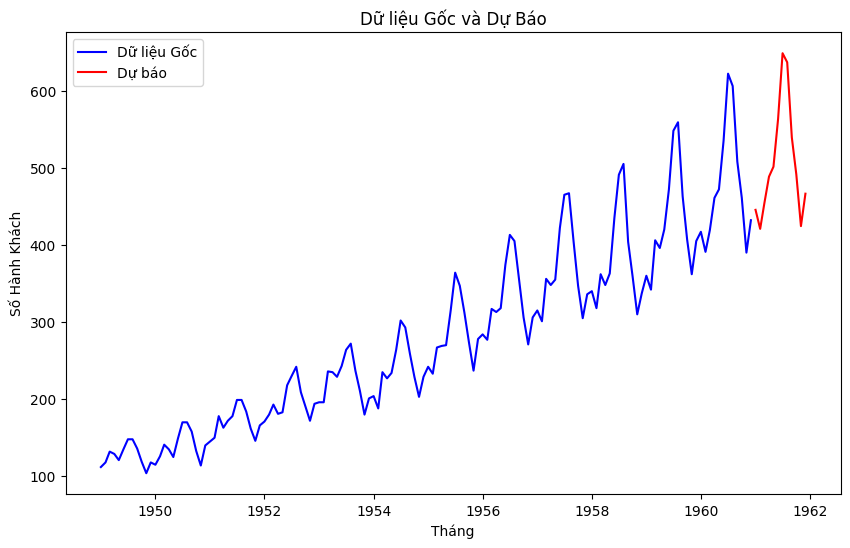

In [27]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Tải mô hình đã lưu
with open('best_sarima_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Đọc dữ liệu
data = pd.read_csv("AirPassengers.csv")
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data = data['Passengers']

# Dự báo 12 tháng tiếp theo
forecast_steps = 12
forecast = model.forecast(steps=forecast_steps)

# Tạo danh sách tháng dự báo
forecast_index = [data.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)]

# Vẽ biểu đồ dữ liệu gốc và dữ liệu dự báo
plt.figure(figsize=(10, 6))
plt.plot(data, label='Dữ liệu Gốc', color='blue')  # Dữ liệu gốc (xanh)
plt.plot(forecast_index, forecast, label='Dự báo', color='red')  # Dữ liệu dự báo (đỏ)
plt.legend()

plt.title('Dữ liệu Gốc và Dự Báo')
plt.xlabel('Tháng')
plt.ylabel('Số Hành Khách')
plt.show()
